In [82]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [83]:
import sys
sys.path.append('/home/dmoi/projects/foldtree2')
#read the afdb clusters file
import pandas as pd
import numpy as np
import glob
import os
#autoreload
import pickle
from src import AFDB_tools
import toytree
import tqdm
from matplotlib import pyplot as plt
import torch
from converter import pdbgraph
converter = pdbgraph.PDB2PyG()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [84]:
modelname = 'small5_geo_graph'

with open( modelname + '.pkl', 'rb') as f:
	encoder, decoder = pickle.load(f)

encoder.eval()
decoder.eval()	
encoder.to(device)
decoder.to(device)

HeteroGAE_Decoder(
  (convs): ModuleList(
    (0-4): 5 x HeteroConv(num_relations=2)
  )
  (norms): ModuleList(
    (0-4): 5 x LayerNorm((75,), eps=1e-05, elementwise_affine=True)
  )
  (bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_foldx): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.001, inplace=False)
  (jk): JumpingKnowledge(cat)
  (sigmoid): Sigmoid()
  (lin): Sequential(
    (0): LayerNorm((375,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=375, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
    (4): GELU(approximate='none')
    (5): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
  )
  (aadecoder): Sequential(
    (0): Linear(in_features=420, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3):

In [85]:
from torch_geometric.data import DataLoader , HeteroData

struct_dat = pdbgraph.StructureDataset('structalignmk4.h5')
#struct_dat = ft2.StructureDataset('structs_training.h5')
encoder_loader = DataLoader(struct_dat, batch_size=1, shuffle=True)
#encode the structures
encode_alns = True
if encode_alns == True:
	def databatch2list(loader , limit = 10):
		for i,data in enumerate(loader):
			if i > limit:
				break
			data = data.to_data_list()
			for d in data:
				d = d.to(device)
				yield d
	encoder_loader = databatch2list(encoder_loader)
	encoder.encode_structures_fasta(encoder_loader , modelname+'_aln_encoded_test.fasta' )

/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
0it [00:00, ?it/s]

11it [00:00, 21.45it/s]


In [86]:
encoded_fasta =  modelname+'_aln_encoded_test.fasta' 
seqstr = ''
ID = ''
seqdict = {}
with open(encoded_fasta, 'r') as f:
	#read all chars of file into a string
	for line in tqdm.tqdm(f):
		if line[0] == '>' and line[-1] == '\n':
			seqdict[ID] = seqstr
			ID = line[1:].strip()
			seqstr = ''
		else:
			seqstr += line.strip()
del seqdict['']
encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#change index to protid
encoded_df.index = encoded_df.protid
encoded_df = encoded_df.drop( 'protid', axis=1 )

encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
#hex starts at 1
encoded_df['hex2'] = encoded_df.ord.map( lambda x: [ hex(c) for c in x] )

105it [00:00, 150616.25it/s]


In [87]:
charset = 249
#make fasta is shifted by 1 and goes from 1-248 included
#0x01 – 0xFF excluding > (0x3E), = (0x3D), < (0x3C), - (0x2D), Space (0x20), Carriage Return (0x0d) and Line Feed (0x0a)
#replace 0x22 or " which is necesary for nexus files and 0x23 or # which is also necesary

replace_dict = {chr(0):chr(246) , '"':chr(248) , '#':chr(247), '>' : chr(249), '=' : chr(250), '<' : chr(251), '-' : chr(252), ' ' : chr(253) , '\r' : chr(254), '\n' : chr(255) }
rev_replace_dict = { v:k for k,v in replace_dict.items() }

replace_dict_ord = { ord(k):ord(v) for k,v in replace_dict.items() }
rev_replace_dict_ord = { ord(v):ord(k) for k,v in replace_dict.items() }

print(replace_dict)
print(rev_replace_dict)

print( replace_dict_ord )

print(rev_replace_dict_ord)

{'\x00': 'ö', '"': 'ø', '#': '÷', '>': 'ù', '=': 'ú', '<': 'û', '-': 'ü', ' ': 'ý', '\r': 'þ', '\n': 'ÿ'}
{'ö': '\x00', 'ø': '"', '÷': '#', 'ù': '>', 'ú': '=', 'û': '<', 'ü': '-', 'ý': ' ', 'þ': '\r', 'ÿ': '\n'}
{0: 246, 34: 248, 35: 247, 62: 249, 61: 250, 60: 251, 45: 252, 32: 253, 13: 254, 10: 255}
{246: 0, 248: 34, 247: 35, 249: 62, 250: 61, 251: 60, 252: 45, 253: 32, 254: 13, 255: 10}


In [88]:
encoded_df.seq = encoded_df.seq.map(lambda x : ''.join([ c if c not in replace_dict else replace_dict[c] for c in x]))
print(encoded_df)

                                                          seq  \
protid                                                          
A0A3L7IL51  %\t&&&&&&%%%%%ý...   
A0A836SY22  %\t%%''&&%&%...   
A0A268IF33  %%\t&ø%!%ý%'...   
A0A3P7M2Y4  (('!(((!(...   
A0A5N0UMS4  &ø&&!ø'$...   
A0A2J7QT95  '!%'%øýý%%...   
Q2HG01      &&&&&&\&!&...   
A0A1G9Z4G4  &'&%!øøøø!!\t&$...   
W9WPN2      (!!(...   
A0A662WQU0  &%%&&%&&ø!...   

                                                          ord  \
protid                                                          
A0A3L7IL51  [37, 29, 9, 38, 27, 3, 1, 7, 38, 11, 1, 11, 27...   
A0A836SY22  [1, 2, 1, 1, 2, 37, 2, 11, 9, 37, 37, 39, 

In [89]:
import py3Dmol

def view_custom_pdb(pdb_file, chain='A'):
	"""
	Visualize a PDB structure from a file, highlight a specific residue with thicker sticks,
	show the backbone for the selected residue, and add an arrow-like indicator.
	
	Parameters:
	- pdb_file: str, path to the local PDB file.
	- residue_num: int, residue number to highlight.
	- chain: str, the chain identifier (default 'A').
	"""
	# Read the PDB file content
	with open(pdb_file, 'r') as f:
		pdb_content = f.read()

	# Initialize py3Dmol viewer
	viewer = py3Dmol.view(width=800, height=600)
	
	# Add the PDB structure to the viewer
	viewer.addModel(pdb_content, 'pdb')
	
	# Apply cartoon style for the overall structure
	viewer.setStyle({'cartoon': {'color': 'cyan'}})
	
	
	# Add molecular surface for the rest of the structure
	viewer.addSurface(py3Dmol.VDW, {'opacity': 0.5})
	
	
	# Set zoom and background color
	viewer.zoomTo()
	viewer.setBackgroundColor('white')
	
	# Show the structure
	return viewer.show()



A0A3L7IL51


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

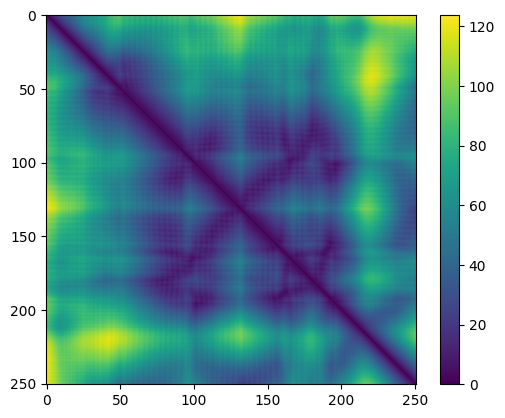

243
torch.Size([243, 20])
HeteroData(
  res={
    x=[243, 20],
    batch=[243],
  },
  positions={ x=[243, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 242] },
  (res, backbone_rev, res)={ edge_index=[2, 242] },
  (godnode4decoder, informs, res)={ edge_index=[2, 243] },
  (res, informs, godnode4decoder)={ edge_index=[2, 243] },
  (res, informs, godnode)={ edge_index=[2, 243] }
)
torch.Size([59049])
tensor([[-1.8823e+01, -1.0239e+01, -1.2943e+01,  ..., -1.7520e+01,
         -1.5476e+01, -1.7703e+01],
        [-1.4369e+01, -1.1529e+01, -1.3761e+01,  ..., -1.1407e+01,
         -1.1641e+01, -1.7230e+01],
        [-1.5515e+01, -1.4665e+01, -1.6963e+01,  ..., -1.6572e+01,
         -1.4378e+01, -1.4803e+01],
        ...,
        [-1.6487e+01, -1.5825e+01, -1.5648e+01,  ..., -1.7457e+01,
         -1.4508e+01, -1.4196e+01],
        [-1.0133e-05, -1.4898e+01, -1.7925e+01,  ..., -1.7637e+01,
         -1.4237e+01, -1.4182e+01],
        [-1

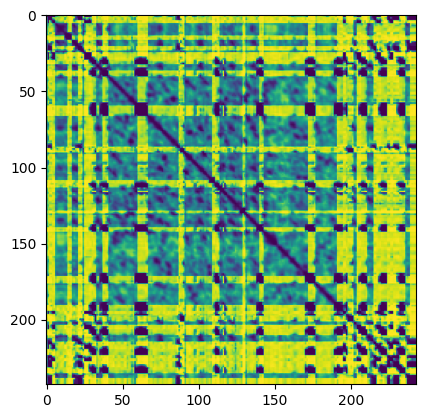

torch.Size([243, 243])
(251, 251)


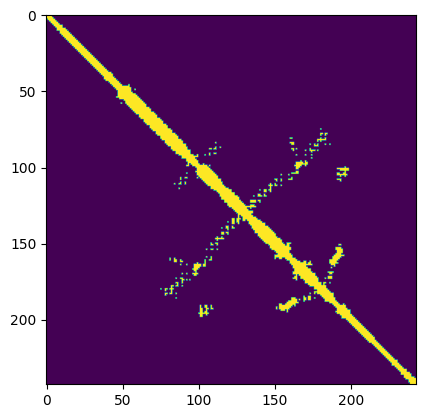

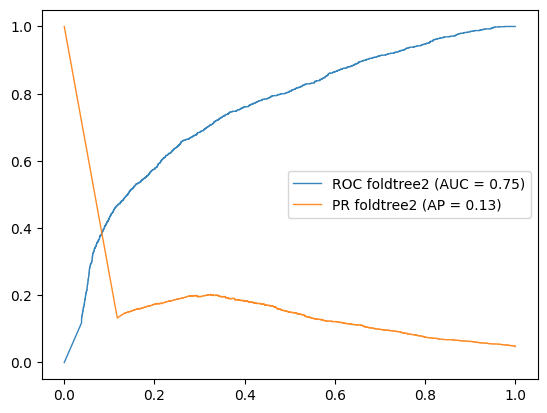

A0A836SY22


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

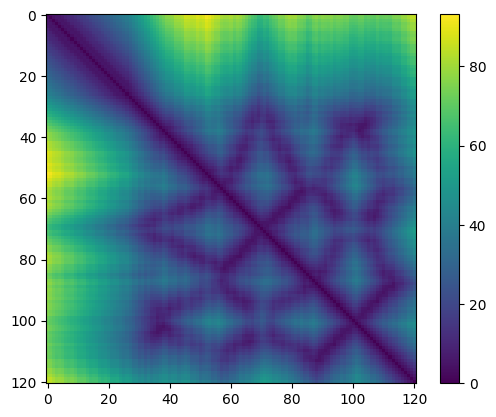

94
torch.Size([94, 20])
HeteroData(
  res={
    x=[94, 20],
    batch=[94],
  },
  positions={ x=[94, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 93] },
  (res, backbone_rev, res)={ edge_index=[2, 93] },
  (godnode4decoder, informs, res)={ edge_index=[2, 94] },
  (res, informs, godnode4decoder)={ edge_index=[2, 94] },
  (res, informs, godnode)={ edge_index=[2, 94] }
)
torch.Size([8836])
tensor([[-14.5542, -17.4560, -16.5248,  ..., -20.8197, -17.1324, -14.1303],
        [-17.5539, -16.4149, -15.4127,  ..., -16.4405, -13.6731, -12.2322],
        [-14.5018, -17.4241, -16.5979,  ..., -20.8651, -17.1352, -14.2549],
        ...,
        [-14.8433, -17.5244, -16.2365,  ..., -20.6320, -17.1070, -13.6201],
        [-16.4889, -15.8224, -15.6549,  ..., -17.4597, -14.5199, -14.1983],
        [-16.4889, -15.8224, -15.6549,  ..., -17.4597, -14.5199, -14.1983]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[0.9974, 0.9956, 

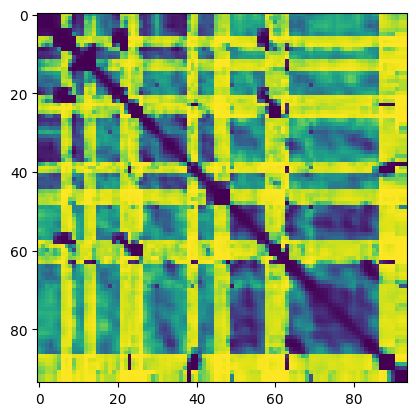

torch.Size([94, 94])
(121, 121)


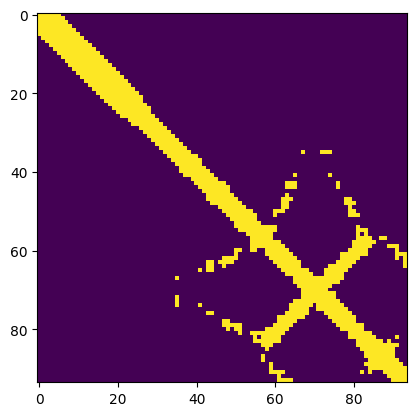

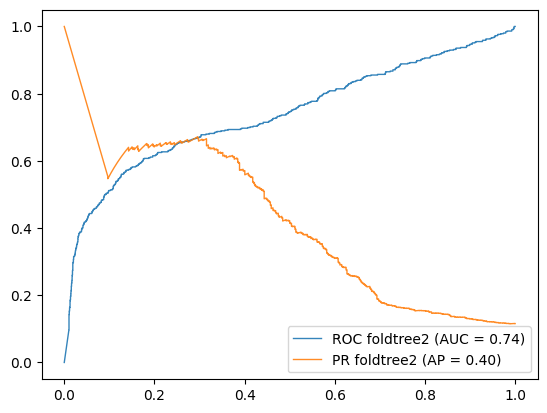

A0A268IF33


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

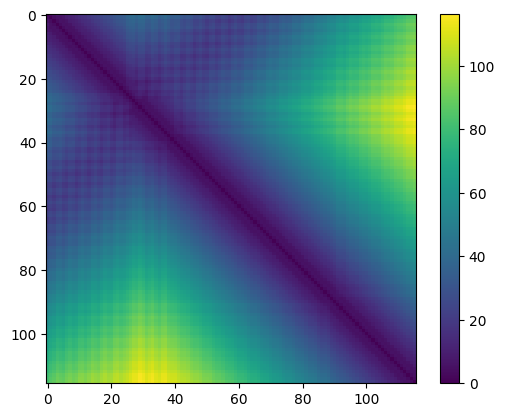

112
torch.Size([112, 20])
HeteroData(
  res={
    x=[112, 20],
    batch=[112],
  },
  positions={ x=[112, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 111] },
  (res, backbone_rev, res)={ edge_index=[2, 111] },
  (godnode4decoder, informs, res)={ edge_index=[2, 112] },
  (res, informs, godnode4decoder)={ edge_index=[2, 112] },
  (res, informs, godnode)={ edge_index=[2, 112] }
)
torch.Size([12544])
tensor([[-1.8014e+01, -1.2144e+01, -2.6226e-05,  ..., -1.4024e+01,
         -1.3306e+01, -1.3232e+01],
        [-1.8650e+01, -8.9259e+00, -1.3277e+01,  ..., -1.7463e+01,
         -1.6505e+01, -1.7736e+01],
        [-1.8861e+01, -1.0083e+01, -1.3193e+01,  ..., -1.7471e+01,
         -1.5945e+01, -1.7736e+01],
        ...,
        [-1.8046e+01, -1.4713e+01, -1.8092e+01,  ..., -1.7430e+01,
         -2.0358e+01, -1.5946e+01],
        [-1.8033e+01, -1.4721e+01, -1.8090e+01,  ..., -1.7444e+01,
         -2.0359e+01, -1.5935e+01],
        [-1

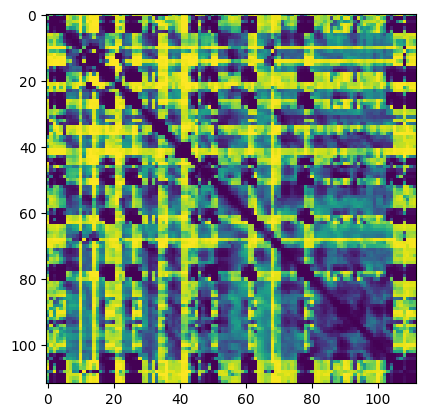

torch.Size([112, 112])
(116, 116)


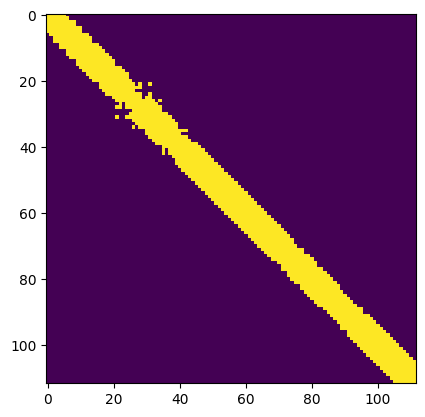

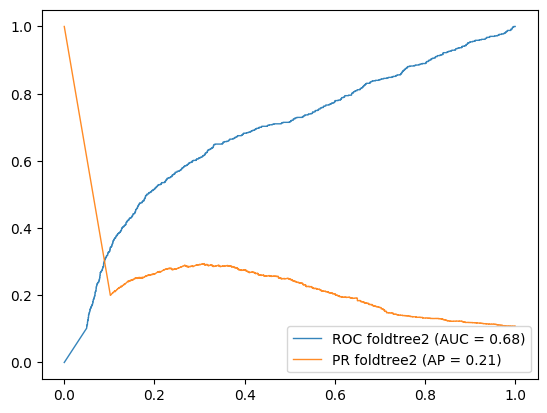

A0A3P7M2Y4


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

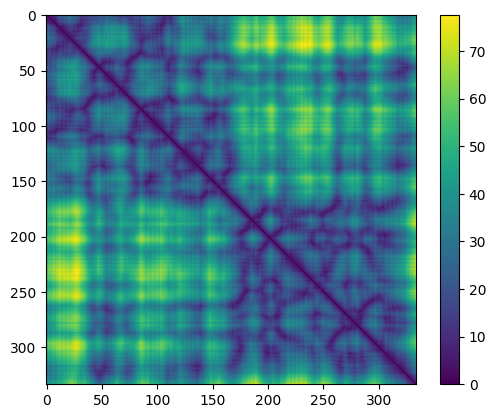

323
torch.Size([323, 20])
HeteroData(
  res={
    x=[323, 20],
    batch=[323],
  },
  positions={ x=[323, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 322] },
  (res, backbone_rev, res)={ edge_index=[2, 322] },
  (godnode4decoder, informs, res)={ edge_index=[2, 323] },
  (res, informs, godnode4decoder)={ edge_index=[2, 323] },
  (res, informs, godnode)={ edge_index=[2, 323] }
)
torch.Size([104329])
tensor([[-1.3252e+01, -1.4394e+01, -1.6726e+01,  ..., -1.8708e+01,
         -1.4548e+01, -1.4020e+01],
        [-1.8164e+01, -1.4712e+01, -1.8150e+01,  ..., -1.7268e+01,
         -2.0328e+01, -1.6099e+01],
        [-1.4728e+01, -1.6203e+01, -1.5296e+01,  ..., -1.7712e+01,
         -1.6202e+01, -4.8875e-05],
        ...,
        [-1.3706e+01, -1.5595e+01, -1.5723e+01,  ..., -1.7110e+01,
         -1.4980e+01, -1.5728e+01],
        [-1.3887e+01, -1.6058e+01, -1.6158e+01,  ..., -1.7020e+01,
         -1.5195e+01, -1.5786e+01],
        [-

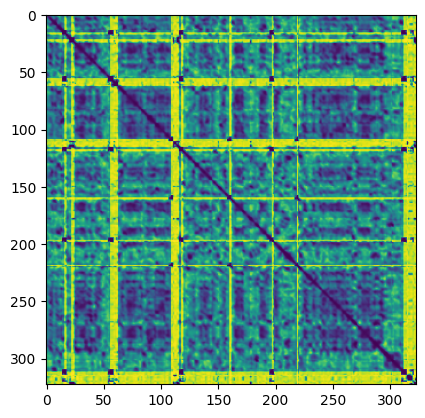

torch.Size([323, 323])
(334, 334)


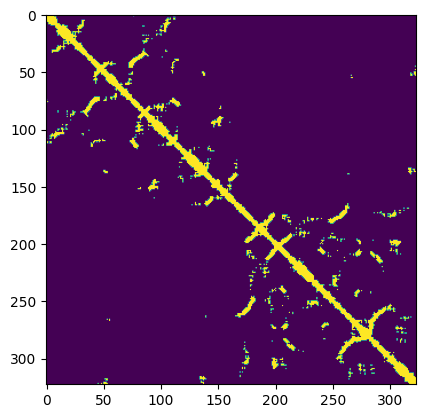

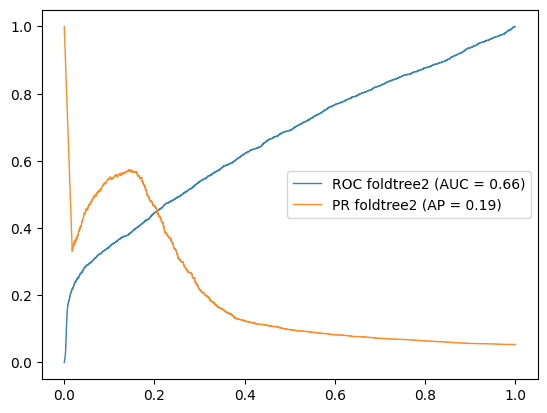

A0A5N0UMS4


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

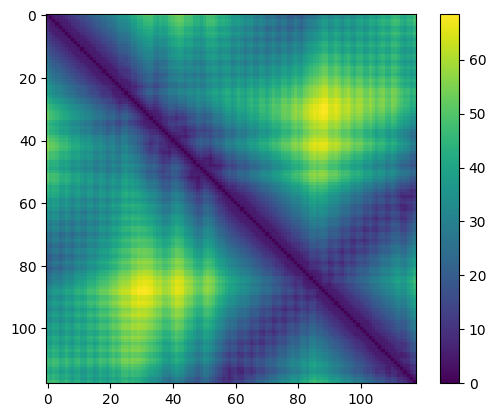

111
torch.Size([111, 20])
HeteroData(
  res={
    x=[111, 20],
    batch=[111],
  },
  positions={ x=[111, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 110] },
  (res, backbone_rev, res)={ edge_index=[2, 110] },
  (godnode4decoder, informs, res)={ edge_index=[2, 111] },
  (res, informs, godnode4decoder)={ edge_index=[2, 111] },
  (res, informs, godnode)={ edge_index=[2, 111] }
)
torch.Size([12321])
tensor([[-1.6308e+01, -1.5772e+01, -1.5343e+01,  ..., -1.7237e+01,
         -1.4202e+01, -1.4306e+01],
        [-1.4655e+01, -1.7495e+01, -1.6624e+01,  ..., -2.0942e+01,
         -1.7162e+01, -1.4209e+01],
        [-1.4553e+01, -1.6310e+01, -1.5307e+01,  ..., -1.7702e+01,
         -1.6123e+01, -4.1484e-05],
        ...,
        [-1.4585e+01, -1.7494e+01, -1.6513e+01,  ..., -2.0734e+01,
         -1.7024e+01, -1.4068e+01],
        [-1.8114e+01, -1.5875e+01, -1.1862e+01,  ..., -1.6730e+01,
         -2.0695e+01, -1.6539e+01],
        [-1

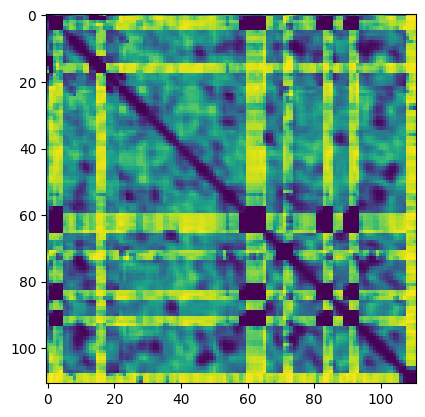

torch.Size([111, 111])
(118, 118)


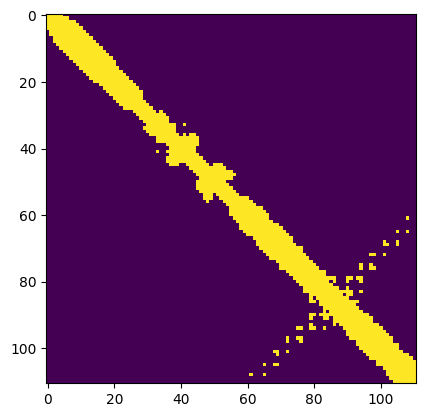

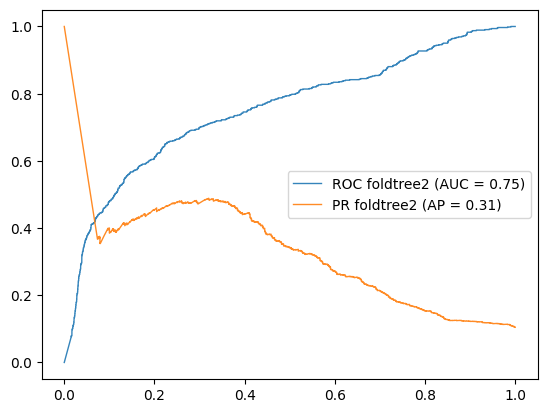

A0A2J7QT95


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

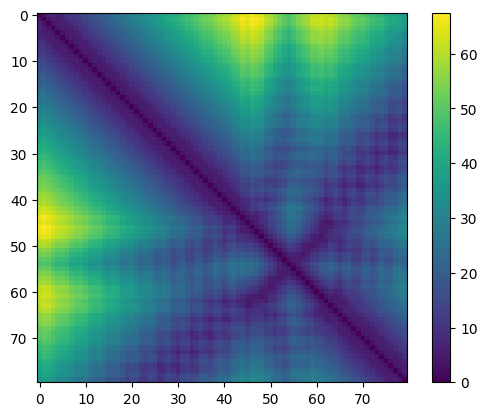

78
torch.Size([78, 20])
HeteroData(
  res={
    x=[78, 20],
    batch=[78],
  },
  positions={ x=[78, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 77] },
  (res, backbone_rev, res)={ edge_index=[2, 77] },
  (godnode4decoder, informs, res)={ edge_index=[2, 78] },
  (res, informs, godnode4decoder)={ edge_index=[2, 78] },
  (res, informs, godnode)={ edge_index=[2, 78] }
)
torch.Size([6084])
tensor([[-1.2917e+01, -1.4302e+01, -1.6804e+01,  ..., -1.8591e+01,
         -1.4472e+01, -1.4158e+01],
        [-1.8012e+01, -1.2146e+01, -2.6226e-05,  ..., -1.4021e+01,
         -1.3304e+01, -1.3227e+01],
        [-1.3744e+01, -1.5866e+01, -1.6348e+01,  ..., -1.6655e+01,
         -1.4673e+01, -1.5927e+01],
        ...,
        [-1.4170e+01, -1.6275e+01, -1.5305e+01,  ..., -1.7540e+01,
         -1.5999e+01, -3.4212e-05],
        [-1.7353e+01, -3.2424e-05, -1.1572e+01,  ..., -1.1874e+01,
         -1.6408e+01, -1.6828e+01],
        [-1.7398e+01, 

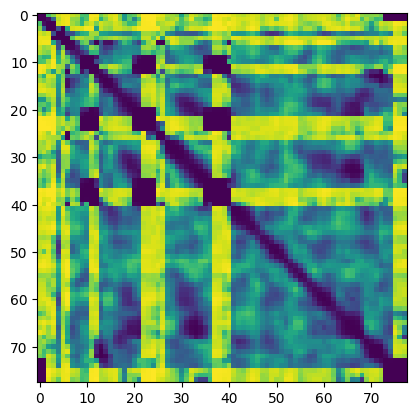

torch.Size([78, 78])
(80, 80)


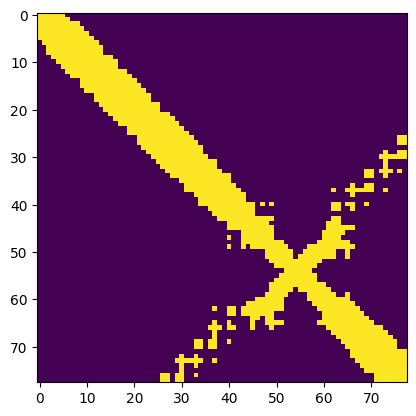

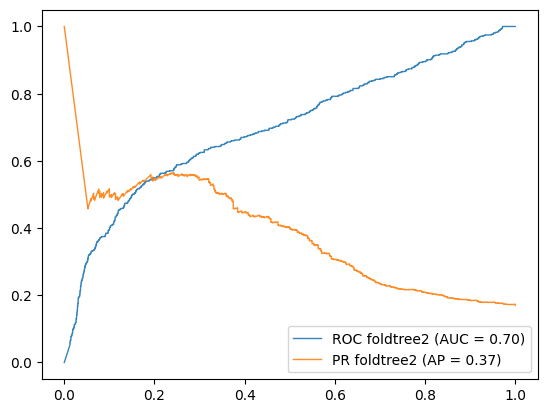

Q2HG01


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

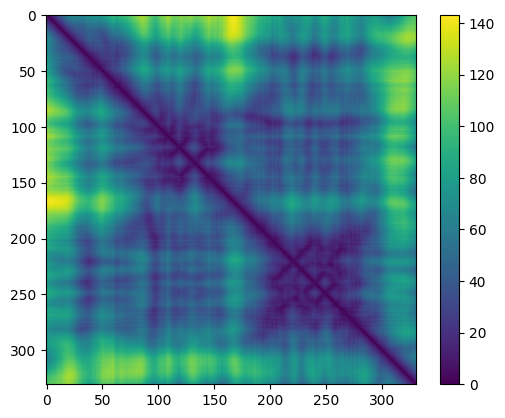

306
torch.Size([306, 20])
HeteroData(
  res={
    x=[306, 20],
    batch=[306],
  },
  positions={ x=[306, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 305] },
  (res, backbone_rev, res)={ edge_index=[2, 305] },
  (godnode4decoder, informs, res)={ edge_index=[2, 306] },
  (res, informs, godnode4decoder)={ edge_index=[2, 306] },
  (res, informs, godnode)={ edge_index=[2, 306] }
)
torch.Size([93636])
tensor([[-1.7787e+01, -1.0273e+01, -1.9817e+01,  ..., -1.0705e+01,
         -1.8141e+01, -1.9337e+01],
        [-1.5934e+01, -1.4686e+01, -1.3066e+01,  ..., -1.1742e+01,
         -9.3217e-05, -1.4862e+01],
        [-1.3203e+01, -1.6796e+01, -1.7053e+01,  ..., -1.9731e+01,
         -1.3768e+01, -1.6141e+01],
        ...,
        [-1.2922e+01, -1.6902e+01, -1.7374e+01,  ..., -1.9641e+01,
         -1.4452e+01, -1.6224e+01],
        [-1.4489e+01, -1.6178e+01, -1.5174e+01,  ..., -1.7642e+01,
         -1.6139e+01, -4.4702e-05],
        [-1

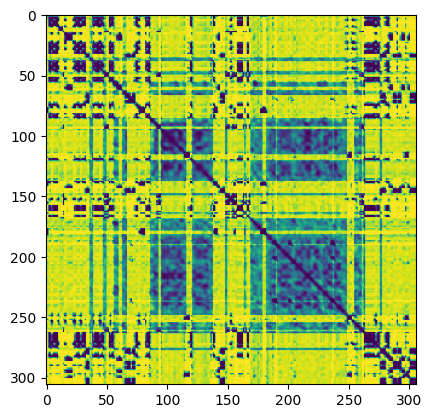

torch.Size([306, 306])
(331, 331)


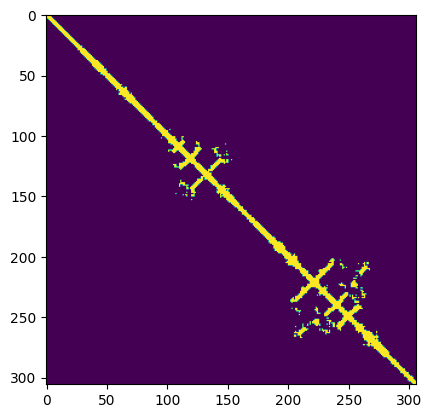

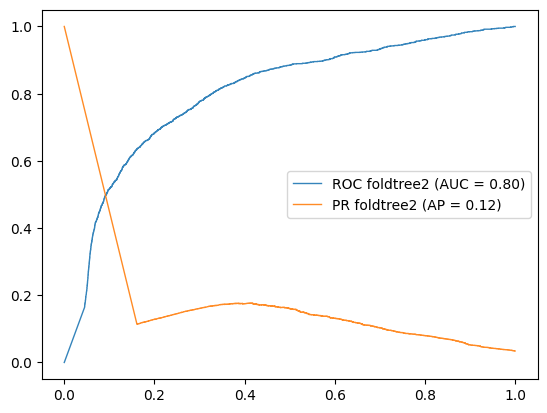

A0A1G9Z4G4


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

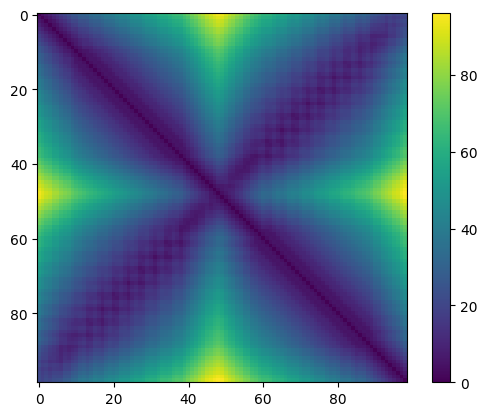

86
torch.Size([86, 20])
HeteroData(
  res={
    x=[86, 20],
    batch=[86],
  },
  positions={ x=[86, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 85] },
  (res, backbone_rev, res)={ edge_index=[2, 85] },
  (godnode4decoder, informs, res)={ edge_index=[2, 86] },
  (res, informs, godnode4decoder)={ edge_index=[2, 86] },
  (res, informs, godnode)={ edge_index=[2, 86] }
)
torch.Size([7396])
tensor([[-14.0678, -15.9810, -15.8562,  ..., -17.0413, -15.0628, -16.0408],
        [-17.8329, -10.2034, -19.9066,  ..., -10.8780, -18.2159, -19.4268],
        [-14.0579, -15.9858, -15.8656,  ..., -17.0069, -15.0486, -16.0142],
        ...,
        [-13.7116, -15.6024, -15.7437,  ..., -17.0955, -14.9695, -15.7336],
        [-14.8494, -17.5280, -16.2386,  ..., -20.6211, -17.0973, -13.6108],
        [-17.9897, -15.7200, -11.6509,  ..., -16.5450, -20.6364, -16.4191]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000, 1.0000, 

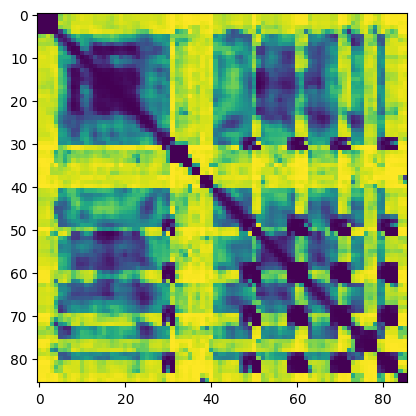

torch.Size([86, 86])
(99, 99)


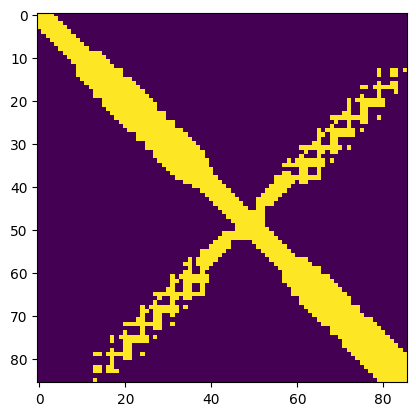

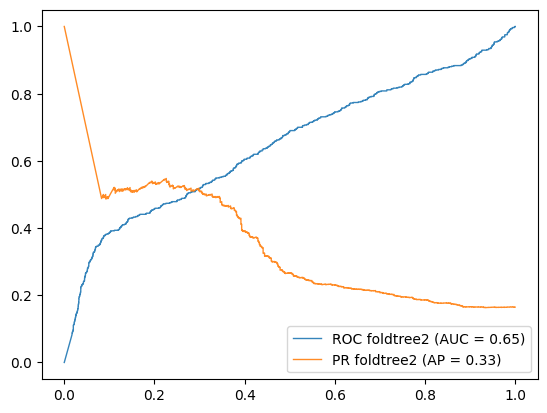

W9WPN2


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

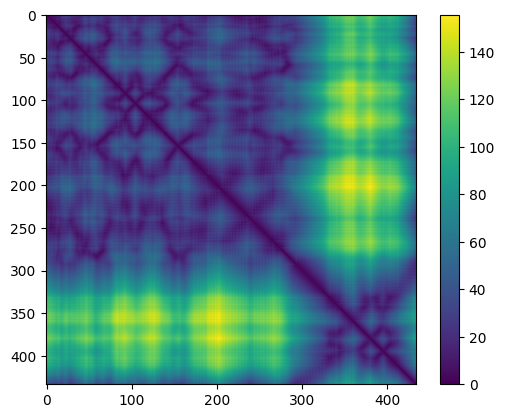

419
torch.Size([419, 20])
HeteroData(
  res={
    x=[419, 20],
    batch=[419],
  },
  positions={ x=[419, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 418] },
  (res, backbone_rev, res)={ edge_index=[2, 418] },
  (godnode4decoder, informs, res)={ edge_index=[2, 419] },
  (res, informs, godnode4decoder)={ edge_index=[2, 419] },
  (res, informs, godnode)={ edge_index=[2, 419] }
)
torch.Size([175561])
tensor([[-14.6501, -17.5073, -16.4821,  ..., -20.7812, -17.0952, -13.9985],
        [-17.4035, -16.2837, -15.4228,  ..., -16.3959, -13.9193, -12.2022],
        [-18.2144, -14.6676, -18.0145,  ..., -17.1697, -20.4033, -15.9763],
        ...,
        [-13.2051, -16.7937, -17.0514,  ..., -19.7341, -13.7731, -16.1382],
        [-18.1919, -14.6762, -17.9822,  ..., -17.1902, -20.4220, -15.9384],
        [-16.4889, -15.8224, -15.6549,  ..., -17.4597, -14.5199, -14.1983]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[0.99

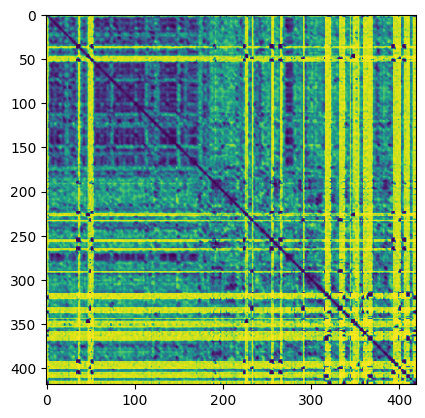

torch.Size([419, 419])
(434, 434)


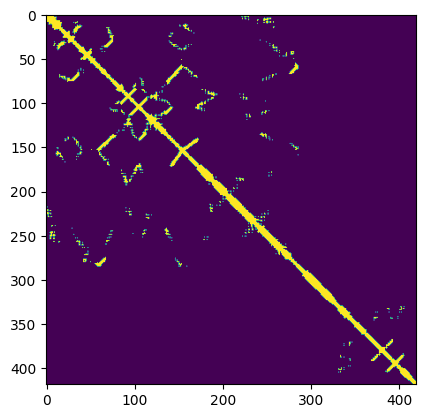

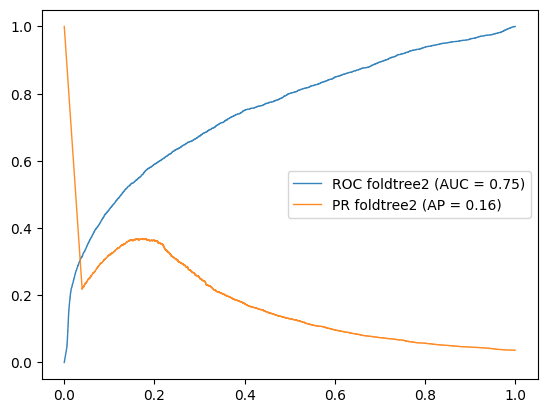

A0A662WQU0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

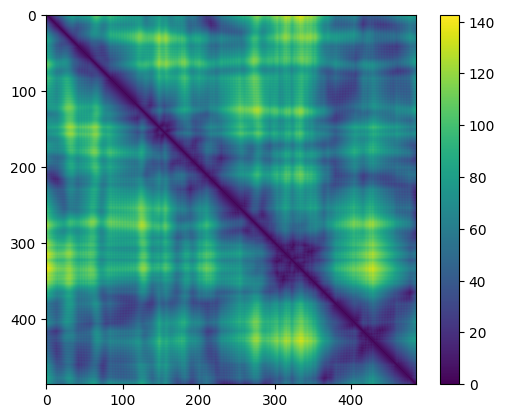

462
torch.Size([462, 20])
HeteroData(
  res={
    x=[462, 20],
    batch=[462],
  },
  positions={ x=[462, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 461] },
  (res, backbone_rev, res)={ edge_index=[2, 461] },
  (godnode4decoder, informs, res)={ edge_index=[2, 462] },
  (res, informs, godnode4decoder)={ edge_index=[2, 462] },
  (res, informs, godnode)={ edge_index=[2, 462] }
)
torch.Size([213444])
tensor([[-1.3964e+01, -1.6059e+01, -1.6150e+01,  ..., -1.6919e+01,
         -1.5084e+01, -1.5932e+01],
        [-1.6331e+01, -1.5802e+01, -1.5411e+01,  ..., -1.7251e+01,
         -1.4210e+01, -1.4284e+01],
        [-1.3230e+01, -1.4407e+01, -1.6731e+01,  ..., -1.8723e+01,
         -1.4673e+01, -1.3771e+01],
        ...,
        [-1.0729e-05, -1.5109e+01, -1.7972e+01,  ..., -1.7958e+01,
         -1.4562e+01, -1.4073e+01],
        [-1.4650e+01, -1.7482e+01, -1.6628e+01,  ..., -2.0933e+01,
         -1.7185e+01, -1.4171e+01],
        [-

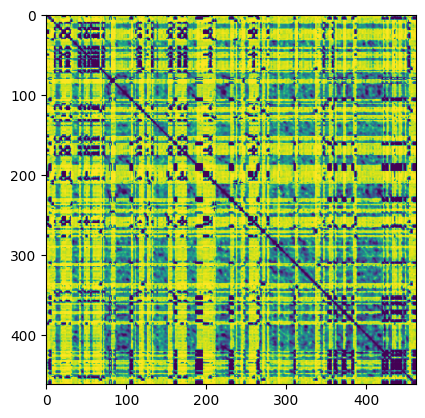

torch.Size([462, 462])
(486, 486)


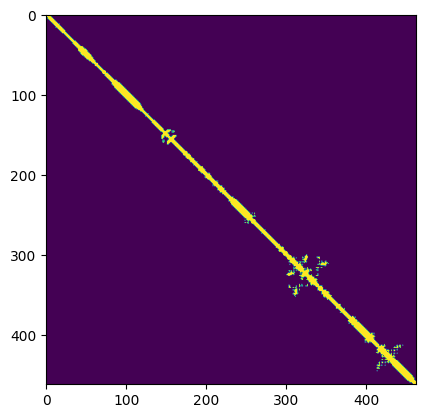

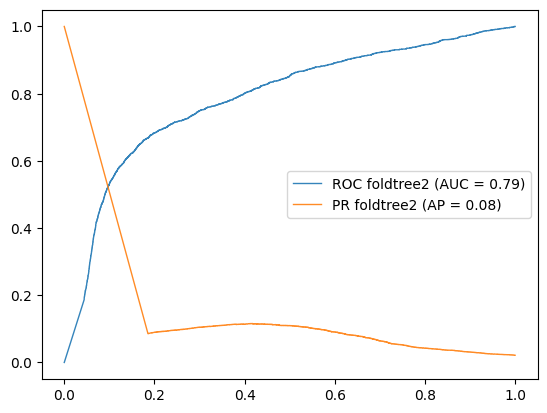

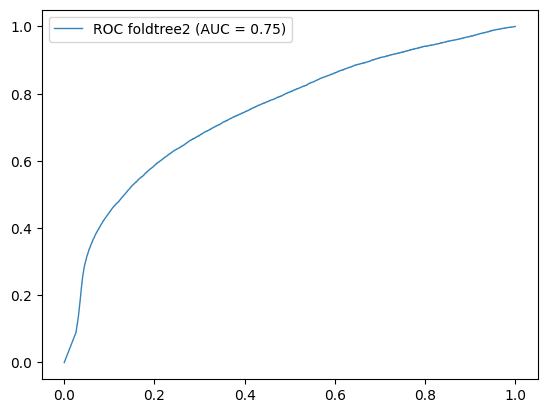

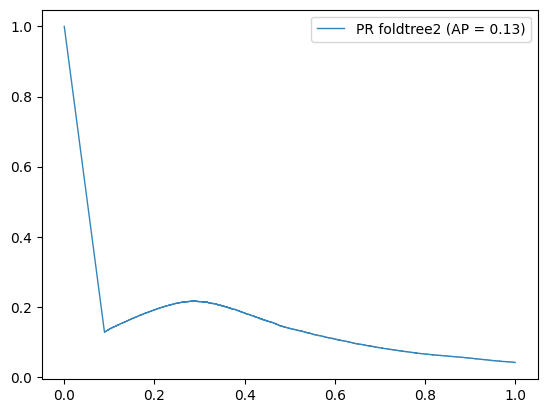

In [90]:
from Bio import PDB
from Bio.PDB import PDBParser
from sklearn.metrics import roc_curve, auc , precision_recall_curve, average_precision_score
from scipy import sparse
import torch_geometric

def get_alpha_carbon_distance_matrix(pdb_file):
	"""
	Extracts the alpha carbon (Cα) atoms from a PDB structure
	and computes the distance matrix in numpy format.

	Parameters:
	pdb_file (str): Path to the PDB file.

	Returns:
	numpy.ndarray: A matrix of distances between all Cα atoms.
	"""
	# Initialize the PDB parser
	parser = PDBParser(QUIET=True)
	
	# Parse the structure
	structure = parser.get_structure('structure', pdb_file)
	
	# Extract alpha carbon (Cα) atoms
	ca_atoms = []
	for model in structure:
		for chain in model:
			for residue in chain :
				if 'CA' in residue and PDB.is_aa(residue) :
					ca_atoms.append(residue['CA'])
	
	# Get the number of Cα atoms
	num_atoms = len(ca_atoms)
	
	# Initialize the distance matrix
	dist_matrix = np.zeros((num_atoms, num_atoms))
	
	# Compute the distances between all pairs of Cα atoms
	for i, atom_i in enumerate(ca_atoms):
		for j, atom_j in enumerate(ca_atoms):
			if i < j:
				dist_matrix[i, j] = atom_i - atom_j
	dist_matrix += dist_matrix.T
	return dist_matrix

#get aa and contacts
def get_backbone(naa):
	backbone_mat = np.zeros((naa, naa))
	backbone_rev_mat = np.zeros((naa, naa))
	np.fill_diagonal(backbone_mat[1:], 1)
	np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
	return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
	sparsemat = sparse.find(sparsemat)
	return np.vstack([sparsemat[0],sparsemat[1]])

def decoder_reconstruction2aa( ords , device, verbose = False):
	decoder.eval()
	z = encoder.vector_quantizer.embeddings( ords  ).to('cpu')
	print( z.shape)
	edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	godnode_index = np.vstack([np.zeros(z.shape[0]), [ i for i in range(z.shape[0]) ] ])
	godnode_rev = np.vstack([ [ i for i in range(z.shape[0]) ] , np.zeros(z.shape[0]) ])
	#generate a backbone for the decoder
	data = HeteroData()
	data['res'].x = z
	backbone, backbone_rev = get_backbone( z.shape[0] )
	backbone = sparse.csr_matrix(backbone)
	backbone_rev = sparse.csr_matrix(backbone_rev)
	backbone = sparse2pairs(backbone)
	backbone_rev = sparse2pairs(backbone_rev)
	positional_encoding = converter.get_positional_encoding( z.shape[0] , 256 )
	data['res'].batch = torch.tensor([0 for i in range(z.shape[0])], dtype=torch.long)
	data['positions'].x = torch.tensor( positional_encoding, dtype=torch.float32)
	data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
	data[ 'res' , 'backbone_rev' , 'res'].edge_index = torch.tensor(backbone_rev, dtype=torch.long)
	#add the godnode
	data['godnode'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder', 'informs', 'res'].edge_index = torch.tensor(godnode_index, dtype=torch.long)
	data['res', 'informs', 'godnode4decoder'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	data['res', 'informs', 'godnode'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	edge_index = edge_index.to( device )
	print( data )
	data = data.to( device )
	allpairs = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	recon_x , edge_probs , zgodnode , foldxout , r, t, angles= decoder( data , allpairs ) 
	print( edge_probs.shape)
	amino_map = decoder.amino_acid_indices
	revmap_aa = { v:k for k,v in amino_map.items() }
	edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
	if verbose == True:
		print( recon_x )
		print( edge_probs )
	aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
	return aastr ,edge_probs

postives = []
predictions = []
for ex in range( encoded_df.shape[0] ):
	os.makedirs('tmp', exist_ok=True)
	example = encoded_df.iloc[ex]
	protid = encoded_df.index[ex]
	ords = example['ord']
	print( str(protid))
	AFDB_tools.grab_struct(str(protid) , structfolder='tmp/')
	#show struct
	view_custom_pdb('tmp/' + protid + '.pdb', chain='A')
	#get alpha carbon distmat with biopython
	s = get_alpha_carbon_distance_matrix( 'tmp/' + protid + '.pdb')
	#threshold the distance matrix
	plt.imshow(s)
	plt.colorbar()
	plt.show()
	#these are the embedding indices. shift by 1 to get the hex indices
	ords = torch.tensor([ c-1 if c not in rev_replace_dict_ord else rev_replace_dict_ord[c]-1 for c in ords] , dtype=torch.long)
	print( len(ords))
	ords = ords.to(device)	
	aa, edgeprobs = decoder_reconstruction2aa( ords , device = device, verbose = True)
	print(aa)
	#change range of image to 0-1
	probs = 1-edgeprobs.detach().cpu()
	probs = (probs + probs.T)/2
	plt.imshow(probs) 
	plt.show()
	print( probs.shape)
	print( s.shape)
	#output ROC curve for contact prediction

	pos = np.zeros( s.shape )
	pos[ s < 10] = 1
	pos = pos[ 0:probs.shape[0], 0:probs.shape[1]]
	plt.imshow(pos)
	plt.show()

	postives.append(pos.flatten())
	predictions.append(probs.flatten())

	#flatten the matrices
	pos = pos.flatten()
	probs = probs.flatten()
	fpr, tpr, thresholds = roc_curve(pos, 1-probs)
	roc_auc = auc(fpr, tpr)
	plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC foldtree2 (AUC = %0.2f)' % (roc_auc))

	#output precision recall curve
	precision, recall, thresholds = precision_recall_curve(pos, 1-probs)
	average_precision = average_precision_score(pos, 1-probs)
	plt.plot(recall, precision, lw=1, alpha=0.9, label='PR foldtree2 (AP = %0.2f)' % (average_precision))
	plt.legend()
	plt.show()

#output ROC curve for contact prediction
postives = np.concatenate(postives)
predictions = np.concatenate(predictions)
fpr, tpr, thresholds = roc_curve(postives, 1-predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC foldtree2 (AUC = %0.2f)' % (roc_auc))
plt.legend()
plt.show()

#output precision recall curve
precision, recall, thresholds = precision_recall_curve(postives, 1-predictions)
average_precision = average_precision_score(postives, 1-predictions)
plt.plot(recall, precision, lw=1, alpha=0.9, label='PR foldtree2 (AP = %0.2f)' % (average_precision))
plt.legend()
plt.show()


In [73]:
# Function to compute Root Mean Square Deviation (RMSD)
def compute_rmsd(coords1, coords2):
    """
    Compute the Root Mean Square Deviation (RMSD) between two sets of coordinates.
    
    Parameters:
    - coords1: Nx3 NumPy array of true coordinates
    - coords2: Nx3 NumPy array of predicted coordinates
    
    Returns:
    - RMSD value
    """
    assert coords1.shape == coords2.shape, "Coordinate arrays must have the same shape"
    
    diff = coords1 - coords2
    rmsd = np.sqrt(np.mean(np.sum(diff**2, axis=1)))
    return rmsd

# Function to compute Local Distance Difference Test (lDDT)
def compute_lddt(true_coords, pred_coords, cutoff=15.0):
    """
    Compute the Local Distance Difference Test (lDDT) score.
    
    Parameters:
    - true_coords: Nx3 NumPy array of true coordinates
    - pred_coords: Nx3 NumPy array of predicted coordinates
    - cutoff: Distance threshold for considering a pair of residues
    
    Returns:
    - lDDT score (0 to 1)
    """
    assert true_coords.shape == pred_coords.shape, "Coordinate arrays must have the same shape"

    num_residues = true_coords.shape[0]
    num_pairs = 0
    num_matching_pairs = 0

    for i in range(num_residues):
        for j in range(i + 1, num_residues):
            true_dist = np.linalg.norm(true_coords[i] - true_coords[j])
            pred_dist = np.linalg.norm(pred_coords[i] - pred_coords[j])

            if true_dist < cutoff:
                num_pairs += 1
                if abs(true_dist - pred_dist) < 0.5 * true_dist:
                    num_matching_pairs += 1

    lddt_score = num_matching_pairs / num_pairs if num_pairs > 0 else 0
    return lddt_score

# Compute RMSD and lDDT
rmsd_value = compute_rmsd(true_coords_from_rt, pred_coords_from_rt)
lddt_value = compute_lddt(true_coords_from_rt, pred_coords_from_rt)

rmsd_value, lddt_value


NameError: name 'true_coords_from_rt' is not defined

In [83]:

#plot the true and predicted structures
def transform_rt_to_coordinates(rotations, translations):
    """
    Given a list of rotation matrices (R) and translation vectors (t),
    generate the global 3D coordinates of the protein backbone.
    
    Parameters:
    - rotations: List of 3x3 rotation matrices
    - translations: List of 3x1 translation vectors
    
    Returns:
    - coords: Nx3 NumPy array representing the backbone in 3D space
    """
    num_residues = len(rotations)
    assert num_residues == len(translations), "Rotation and translation lists must be the same length"
    
    # Initialize the first coordinate at the origin
    coords = [np.array([0, 0, 0, 1])]  # Homogeneous coordinates

    # Apply transformations iteratively
    current_transform = np.eye(4)  # Identity matrix as starting point

    for R, t in zip(rotations, translations):
        # Construct the transformation matrix (4x4)
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t
        
        # Update the cumulative transformation
        current_transform = current_transform @ T
        
        # Transform the point and store the new coordinates
        new_point = current_transform @ np.array([0, 0, 0, 1])  # Homogeneous coordinates
        coords.append(new_point)

    return np.array(coords)[:, :3]  # Convert back to 3D coordinates (drop the homogeneous coordinate)


def plot_protein_structures_with_thicker_lines(true_coords, pred_coords):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot true structure with thicker lines and transparency
    ax.plot(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2], 
            'bo-', alpha=0.5, label='True Structure', linewidth=3, markersize=6)

    # Plot predicted structure with thicker lines and transparency
    ax.plot(pred_coords[:, 0], pred_coords[:, 1], pred_coords[:, 2], 
            'ro-', alpha=0.5, label='Predicted Structure', linewidth=3, markersize=6)

    # Adjusted arrow size
    arrow_size = 0.15  # Keep small arrows

    # Add arrowheads to indicate backbone direction
    for i in range(len(true_coords) - 1):
        ax.quiver(true_coords[i, 0], true_coords[i, 1], true_coords[i, 2],
                  true_coords[i+1, 0] - true_coords[i, 0], 
                  true_coords[i+1, 1] - true_coords[i, 1], 
                  true_coords[i+1, 2] - true_coords[i, 2],
                  color='blue', alpha=0.5, arrow_length_ratio=arrow_size)

    for i in range(len(pred_coords) - 1):
        ax.quiver(pred_coords[i, 0], pred_coords[i, 1], pred_coords[i, 2],
                  pred_coords[i+1, 0] - pred_coords[i, 0], 
                  pred_coords[i+1, 1] - pred_coords[i, 1], 
                  pred_coords[i+1, 2] - pred_coords[i, 2],
                  color='red', alpha=0.5, arrow_length_ratio=arrow_size)

    # Labels and legend
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('True vs Predicted Protein Backbone Structure with Thicker Lines')
    ax.legend()

    plt.show()

# Plot with thicker lines
plot_protein_structures_with_thicker_lines(true_coords, noisy_pred_coords)


NameError: name 'true_coords' is not defined